## Este notebook es encargado de implementar un modelo para realizar la predicción del estado emocional de una sesión de prueba

In [1]:
import pickle
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import sys
from collections import namedtuple

In [2]:
adaboost = "adaboost"
adaboostrf = "adaboost-rf"
knn = "knn"
knngs = "knn-grid-search"
rf = "random-forest"
rfgs = "random-forest-grid-search"
rbf = "svm-rbf"
rbfgs = "svm-rbf-grid-search"
poly = "svm-poly"
polygs = "svm-poly-grid-search"

modelsToRun = [adaboost, adaboostrf, knn, knngs, rf, rfgs]
Model = namedtuple('Model',['name','model'])
models = []

In [3]:
for model in modelsToRun:
    modelLoad = pickle.load(open(f'./models/model-{model}', 'rb'))
    tupleModel = Model(model, modelLoad)
    models.append(tupleModel)

In [4]:
#model = pickle.load(open('./models/model', 'rb'))
# result_val = model.score(xval, yval)
# result_test = model.score(xtest, ytest)

In [5]:
df_1 = pd.read_csv("..//resources//csv//data//sujeto1-rocio-2020-10-25-biometrics.csv")
df_2 = pd.read_csv("..//resources//csv//data//sujeto2-juan-2020-11-01-biometrics.csv")
df_3 = pd.read_csv("..//resources//csv//data//sujeto3-brenda-2020-11-16-biometrics.csv")
df_4 = pd.read_csv("..//resources//csv//data//sujeto4-matias-2020-11-16-biometrics.csv")
df_5 = pd.read_csv("..//resources//csv//data//sujeto5-sebastian-2021-01-05-biometrics.csv")
df_6 = pd.read_csv("..//resources//csv//data//sujeto6-rocio-2021-01-07-biometrics.csv")

df_valence = pd.read_csv("..//resources//csv//data//sujeto7-seb-2021-03-24-biometrics.csv")

df_to_predict = df_valence

df_to_predict.head()

,TimeStamp,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,ArousalMean,ValenceMean,ArousalSD,ValenceSD,PhaseName,MatchesSam,ImageName,HasValence,Valence
0,2021-03-24 19:09:17,92.0,652,0.10,11.88,1,0,0.0,0.0,0.0,0.0,NaN,False,NaN,False,0.0
1,2021-03-24 19:09:18,81.3,738,6.65,12.55,1,0,0.0,0.0,0.0,0.0,NaN,False,NaN,False,0.0
2,2021-03-24 19:09:19,81.7,734,0.00,12.18,1,0,0.0,0.0,0.0,0.0,NaN,False,NaN,False,0.0
3,2021-03-24 19:09:19,85.5,702,0.00,11.76,1,0,0.0,0.0,0.0,0.0,NaN,False,NaN,False,0.0
4,2021-03-24 19:09:20,84.9,707,0.00,11.64,1,0,0.0,0.0,0.0,0.0,NaN,False,NaN,False,0.0


In [6]:
def add_prev_values(df, col):
    df.loc[0, f'{col}-4'] = df.loc[0, col]
    df.loc[0, f'{col}-3'] = df.loc[0, col]
    df.loc[0, f'{col}-2'] = df.loc[0, col]
    df.loc[0, f'{col}-1'] = df.loc[0, col]

    for i in range(0, len(df)):
        if i >= 4:
            df.loc[i, f'{col}-4'] = df.loc[i-4, col]
            df.loc[i, f'{col}-3'] = df.loc[i-3, col]
            df.loc[i, f'{col}-2'] = df.loc[i-2, col]
            df.loc[i, f'{col}-1'] = df.loc[i-1, col]
        else:
            df.loc[i, f'{col}-4'] = df.loc[i, col]
            df.loc[i, f'{col}-3'] = df.loc[i, col]
            df.loc[i, f'{col}-2'] = df.loc[i, col]
            df.loc[i, f'{col}-1'] = df.loc[i, col]

In [7]:
# Función que determina cuando un sujeto se encuentra en un estado de excitación (1) o relajación (0) dado un valor de arousal.
def isAroused(arousal):
    return 0 if arousal < 5 else 1

In [8]:
df_to_standarize = df_to_predict.copy()
    
# Se remueven las mediciones sin estímulo (previas al inicio de estímulos), para no ofuscar el entrenamiento
filterNoArousalMeasurements = df_to_standarize['ArousalMean'] > 0
df_to_standarize = df_to_standarize[filterNoArousalMeasurements]

# remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
# filterNoMatchesSAMMeasurements = filtered1['MatchesSam'] == True
# df_to_standarize = df_to_standarize[filterNoMatchesSAMMeasurements]

# Se agrega la columna Aroused (0/1) para la clasificación binaria
df_to_standarize['Aroused'] = df_to_standarize['ArousalMean'].map(isAroused)

columns_to_standarize = ['HR', 'RR', 'HRV', 'MicroSiemens']
other_columns = ['SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused', 'TimeStamp', 'HasValence', 'Valence', 'ImageName']
all_columns = columns_to_standarize + other_columns

scaler = preprocessing.StandardScaler()
standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

standarized_df_with_rest_of_data = np.append(standarized_df, df_to_standarize[other_columns], axis=1)

# Se convierte a DataFrame
standarized_df_with_rest_of_data = pd.DataFrame(standarized_df_with_rest_of_data, columns=all_columns)

# Se agregan valores imperceptibles de valencia al primer y último registro para poder graficarlo y mantener la escala
standarized_df_with_rest_of_data['HasValence'][0] = 1
standarized_df_with_rest_of_data['Valence'][0] = 0.0001
standarized_df_with_rest_of_data['ImageName'][0] = 'Inicio'
last_row_index = len(standarized_df_with_rest_of_data) - 1
standarized_df_with_rest_of_data['HasValence'][last_row_index] = 1
standarized_df_with_rest_of_data['Valence'][last_row_index] = 0.0001
standarized_df_with_rest_of_data['ImageName'][last_row_index] = 'Fin'

# Conversión de tipos
standarized_df_with_rest_of_data['HR'] = standarized_df_with_rest_of_data['HR'].astype(float)
standarized_df_with_rest_of_data['RR'] = standarized_df_with_rest_of_data['RR'].astype(float)
standarized_df_with_rest_of_data['HRV'] = standarized_df_with_rest_of_data['HRV'].astype(float)
standarized_df_with_rest_of_data['MicroSiemens'] = standarized_df_with_rest_of_data['MicroSiemens'].astype(float)
standarized_df_with_rest_of_data['SCR'] = standarized_df_with_rest_of_data['SCR'].astype(int)
standarized_df_with_rest_of_data['SCR_MIN'] = standarized_df_with_rest_of_data['SCR_MIN'].astype(int)
standarized_df_with_rest_of_data['PhaseName'] = standarized_df_with_rest_of_data['PhaseName']
standarized_df_with_rest_of_data['ArousalMean'] = standarized_df_with_rest_of_data['ArousalMean'].astype(float)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['TimeStamp'] = standarized_df_with_rest_of_data['TimeStamp']
standarized_df_with_rest_of_data['HasValence'] = standarized_df_with_rest_of_data['HasValence'].astype(int)
standarized_df_with_rest_of_data['Valence'] = standarized_df_with_rest_of_data['Valence'].astype(float)
standarized_df_with_rest_of_data['ImageName'] = standarized_df_with_rest_of_data['ImageName']

# Se agregan a cada columna del dataset las X mediciones anteriores en el tiempo para cada una de las siguientes features.
add_prev_values(standarized_df_with_rest_of_data, "HR")
add_prev_values(standarized_df_with_rest_of_data, "HRV")
add_prev_values(standarized_df_with_rest_of_data, "MicroSiemens")

df_to_predict = standarized_df_with_rest_of_data

In [9]:
BestModel = namedtuple('BestModel',['name','score','y_pred'])
bestModel = BestModel("no-model", 0, [])
maxScore = 0

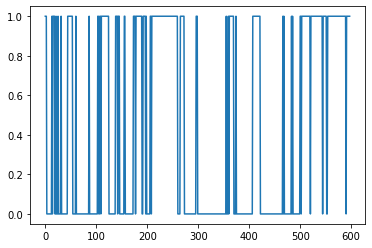

model: adaboost has a score of 0.6053511705685619


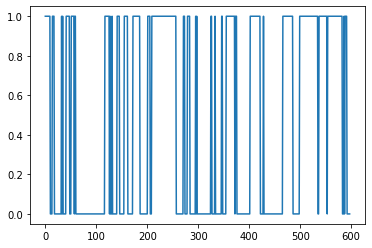

model: adaboost-rf has a score of 0.596989966555184


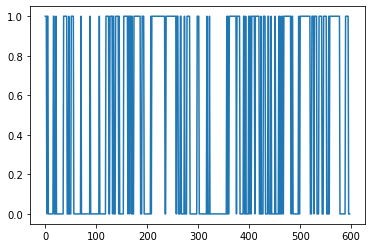

model: knn has a score of 0.49498327759197325


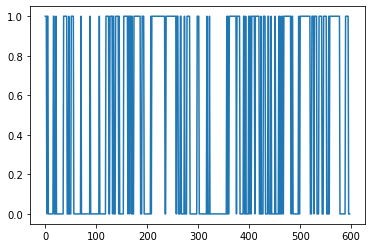

model: knn-grid-search has a score of 0.49498327759197325


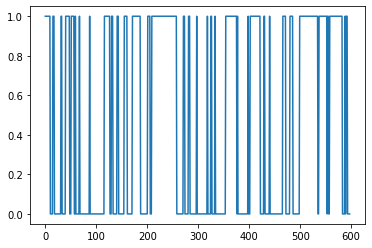

model: random-forest has a score of 0.5886287625418061


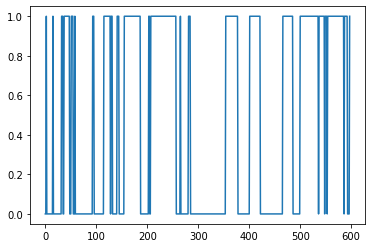

model: random-forest-grid-search has a score of 0.5418060200668896


In [10]:
for model in models:
    y_pred = model.model.predict(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']].values)
    plt.plot(y_pred)
    plt.show()
    score = model.model.score(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']], df_to_predict[['Aroused']])
    print(f"model: {model.name} has a score of {score}")
    if score > maxScore:
        bestModel = BestModel(model.name, score, y_pred)
        maxScore = score
        

In [11]:
print(f"Best model is: {bestModel.name} and has a score of {bestModel.score}")

Best model is: adaboost and has a score of 0.6053511705685619


In [12]:
df_to_predict['ArousalPred'] = bestModel.y_pred

df_to_predict.to_csv(r'./3_prediction.csv', date_format='%s', index = False)
print("Done")

Done
